## knee-method for optional stopping

In [1]:
from asreview import open_state
from asreview import ASReviewProject
from asreview import ASReviewData
import shutil
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


/Users/evaviviani/opt/anaconda3/envs/asreview/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


This function aims to determine stopping criteria based on slopes of relevance scores in a DataFrame. It calculates a knee point where the relevance slope changes significantly.

- k: Minimum number of relevant items to consider stopping.
- 'rho': Threshold ratio to determine if the knee point is found.
- 'df': DataFrame containing two columns: 'category' and 'Relevant by ASReview LAB' / Recall plot

Algorithm found in: https://github.com/MaxvanHaastrecht/ASReview-Knee-Method/blob/main/Cormack%20Grossman%20Knee%20Algorithm.ipynb

Slightly changed to get a plot and some informative prints / comments to understand what's going on

In [189]:
def calculate_knee_values(k, rho, df, plot=True):
    """
    Calculate knee values where the relevance slope changes significantly.

    Parameters:
    k (int): Minimum number of relevant items to consider stopping.
    rho (float): Threshold ratio to determine if the knee point is found.
    df (pd.DataFrame): DataFrame containing 'category' and 'Relevant by ASReview LAB' columns.

    Returns:
    tuple: (stop_i, stop_s, stop_relevant, slope_stop) if stopping criterion is found,
           otherwise (-1, -1, -1, -1).
    """

    # Variables to store stopping values
    stop_i = -1
    stop_s = -1
    stop_relevant = -1
    slope_stop = -1
    
    inflection_found = False

    
    for rank_s, relevant in zip(df['category'], df['Relevant by ASReview LAB']):
        
        # If knee found, break
        if stop_s > 0:
            inflection_found = True
            print('stopping criterion found')
            break
        
        # If number relevant less than k, do not even need to consider stopping
        if relevant < k:
            continue
        
        # Index (start=0) is one lower than rank (start=1)
        index_s = rank_s - 1
        
        # Loop over all i and compare slopes
        for rank_i in range(1, rank_s):
            
            # Calculate slope until i
            index_i = rank_i - 1
            num_relevant_i = df['Relevant by ASReview LAB'][index_i]
            
            slope_i = num_relevant_i / rank_i
            
            # If slope until i is zero, cannot exceed cutoff
            if slope_i == 0:
                continue
            
            num_relevant_s = df['Relevant by ASReview LAB'][index_s]
            
            # Calculate slope of s
            # Add 1 to numerator to avoid edge cases with i very close to s
            slope_s = (1 + num_relevant_s - num_relevant_i) / (rank_s - rank_i)
            
            # Calculate slope ratio
            slope_ratio = slope_i / slope_s
            
            # Check if slope_ratio greater than cutoff
            if slope_ratio > rho:
                stop_i = rank_i
                stop_s = rank_s
                stop_relevant = num_relevant_s
                slope_stop = slope_ratio
                inflection_found = True
                break
                
    if not inflection_found:
        print('No stopping criterion found')
        
    # plot the data
    if plot:
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=df, x='category', y='Relevant by ASReview LAB', 
                     color='k', label='Relevant by ASReview LAB',
                    marker='o')

        if inflection_found:
            plt.axvline(x=stop_s, color='r', linestyle='--', label=f'Inflection Point at rank {stop_s}')

        plt.xlabel('paper number')
        plt.ylabel('Relevant by ASReview LAB')
        plt.legend()
        plt.grid(True)
        plt.show()
                
    return stop_i, stop_s, stop_relevant, slope_stop

### round 1

In [152]:
round1 = pd.read_excel('bib/round1/feedback/predictions-round1_vch-feedback.xlsx', header=0)

In [153]:
round1.head()

,record_id,Unnamed: 0,title,authors,type_of_reference,abstract,language,keywords,doi,ranking,Included
0,5540,5540,Temperature-dependent transmission of rotaviru...,"[""{'author': 'Atchison, C J', 'author_abbrevia...",JOUR,"In Europe, rotavirus gastroenteritis peaks in ...","In Europe, rotavirus gastroenteritis peaks in ...",NaN,10.1098/rspb.2009.1755,0,1.0
1,993,993,Climate variability and campylobacter infectio...,"[""{'author': 'Kovats, R Sari', 'author_abbrevi...",JOUR,Campylobacter is among the most important agen...,eng,NaN,10.1007/s00484-004-0241-3,1,1.0
2,5186,5186,Seasonality and the effects of weather on Camp...,"[""{'author': 'Djennad, Abdelmajid', 'author_ab...",JOUR,BACKGROUND: Campylobacteriosis is a major publ...,eng,"['Campylobacter', 'Climate change', 'Environme...",10.1186/s12879-019-3840-7,2,1.0
3,1566,1566,Determinants of Rotavirus Transmission: A Lag ...,"[""{'author': 'van Gaalen, Rolina D', 'author_a...",JOUR,Rotavirus is a common viral infection among yo...,eng,NaN,10.1097/EDE.0000000000000654,3,1.0
4,3179,3179,Influence of weather and climate on cryptospor...,"[""{'author': 'Ikiroma, Isotein Adalia', 'autho...",JOUR,Studies have shown that climatic factors can s...,eng,"['climate', 'cryptosporidiosis', 'public healt...",10.1111/zph.12785,4,1.0


In [154]:
# pick the first 53
round1_sub = round1[:53]

In [155]:
round1_sub.head()

,record_id,Unnamed: 0,title,authors,type_of_reference,abstract,language,keywords,doi,ranking,Included
0,5540,5540,Temperature-dependent transmission of rotaviru...,"[""{'author': 'Atchison, C J', 'author_abbrevia...",JOUR,"In Europe, rotavirus gastroenteritis peaks in ...","In Europe, rotavirus gastroenteritis peaks in ...",NaN,10.1098/rspb.2009.1755,0,1.0
1,993,993,Climate variability and campylobacter infectio...,"[""{'author': 'Kovats, R Sari', 'author_abbrevi...",JOUR,Campylobacter is among the most important agen...,eng,NaN,10.1007/s00484-004-0241-3,1,1.0
2,5186,5186,Seasonality and the effects of weather on Camp...,"[""{'author': 'Djennad, Abdelmajid', 'author_ab...",JOUR,BACKGROUND: Campylobacteriosis is a major publ...,eng,"['Campylobacter', 'Climate change', 'Environme...",10.1186/s12879-019-3840-7,2,1.0
3,1566,1566,Determinants of Rotavirus Transmission: A Lag ...,"[""{'author': 'van Gaalen, Rolina D', 'author_a...",JOUR,Rotavirus is a common viral infection among yo...,eng,NaN,10.1097/EDE.0000000000000654,3,1.0
4,3179,3179,Influence of weather and climate on cryptospor...,"[""{'author': 'Ikiroma, Isotein Adalia', 'autho...",JOUR,Studies have shown that climatic factors can s...,eng,"['climate', 'cryptosporidiosis', 'public healt...",10.1111/zph.12785,4,1.0


In [156]:
# count how many relevant papers have been found
round1_sub['n_relevant'] = round1_sub['Included'].cumsum()

/var/folders/7r/f1h2yj0s3779qbgqnqntmhgc0000gn/T/ipykernel_72130/2680973143.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  round1_sub['n_relevant'] = round1_sub['Included'].cumsum()


In [157]:
round1_sub['ranking'] = round1_sub['ranking']+1

/var/folders/7r/f1h2yj0s3779qbgqnqntmhgc0000gn/T/ipykernel_72130/3379150696.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  round1_sub['ranking'] = round1_sub['ranking']+1


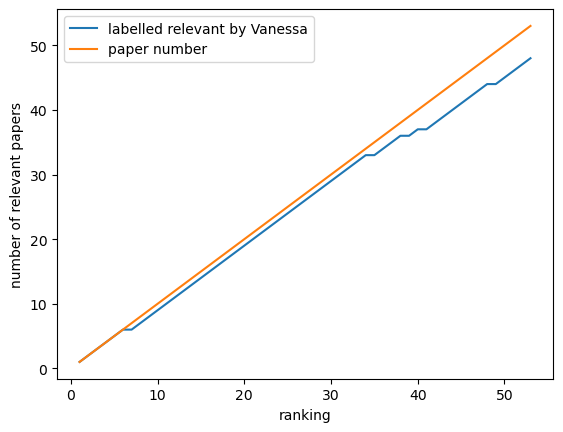

In [158]:
plt.plot(round1_sub['ranking'], round1_sub['n_relevant'], label='labelled relevant by Vanessa')
plt.plot(round1_sub['ranking'], round1_sub['ranking'], label='paper number')
plt.ylabel('number of relevant papers')
plt.xlabel('ranking')
plt.legend()
plt.show()

In [33]:
round1_sub_minimal = round1_sub[['ranking', 'n_relevant']].astype('int')

In [35]:
round1_sub_minimal.head(10)

,ranking,n_relevant
0,1,1
1,2,2
2,3,3
3,4,4
4,5,5
5,6,6
6,7,6
7,8,7
8,9,8
9,10,9


In [36]:
round1_sub_minimal = round1_sub_minimal.rename(columns={"ranking": "category", "n_relevant": "Relevant by ASReview LAB"})

No stopping criterion found


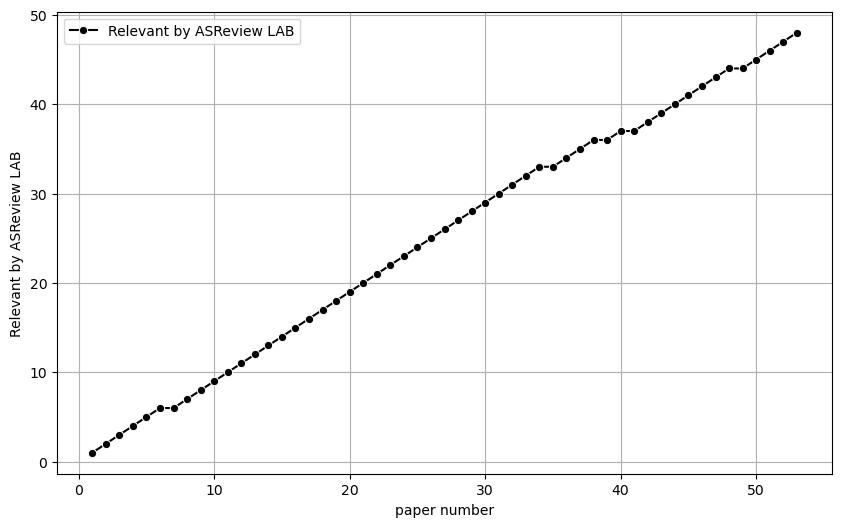

In [37]:
# can we stop already reviewing?
k = 10
rho = 6

# 70% 
i, s, num_relevant, slope_ratio = calculate_knee_values(k, rho, round1_sub_minimal)

In [10]:
# no

In [38]:
### look at the prior knowledge

In [39]:
relevant = ['Temperature-dependent transmission of rotavirus in Great Britain and The Netherlands.',
           'The Influence of Climate and Livestock Reservoirs on Human Cases of Giardiasis.',
           'The seasonality of diarrheal pathogens: A retrospective study of seven sites over three years.',
           'Use of earth observation-derived hydrometeorological variables to model and predict rotavirus infection (MAL-ED): a multisite cohort study.',
           'Seasonality and the effects of weather on Campylobacter infections.',
           'Climate variability and campylobacter infection: an international study.',
           'Determinants of Rotavirus Transmission: A Lag Nonlinear Time Series Analysis.']

irrelevant = ['Associations between Household-Level Exposures and All-Cause Diarrhea and Pathogen-Specific Enteric Infections in Children Enrolled in Five Sentinel Surveillance Studies.',
             'Uncovering social and environmental factors that increase the burden of climate-sensitive diarrheal infections on children.',
             'Full breastfeeding protection against common enteric bacteria and viruses: results from the MAL-ED cohort study.']

In [40]:
np.sum([title in relevant for title in round1['title'].values])

7

In [41]:
priors = [title in relevant for title in round1['title'].values]

In [42]:
np.sum(round1['Included'])

48.0

In [44]:
round1[priors][['record_id','title']]

,record_id,title
0,5540,Temperature-dependent transmission of rotaviru...
1,993,Climate variability and campylobacter infectio...
2,5186,Seasonality and the effects of weather on Camp...
3,1566,Determinants of Rotavirus Transmission: A Lag ...
5,6029,Use of earth observation-derived hydrometeorol...
11,5831,The seasonality of diarrheal pathogens: A retr...
43,5600,The Influence of Climate and Livestock Reservo...


In [45]:
round1[round1['Included'] == 0]

,record_id,Unnamed: 0,title,authors,type_of_reference,abstract,language,keywords,doi,ranking,Included
6,1204,1204,Convulsions in children hospitalized for acute...,"[""{'author': 'Iflah, Moti', 'author_abbreviate...",JOUR,The study aim was to examine possible correlat...,eng,NaN,10.1038/s41598-021-95202-4,6,0.0
34,2246,2246,Evaluating meteorological data from weather st...,"[""{'author': 'Colston, Josh M', 'author_abbrev...",JOUR,BACKGROUND: Longitudinal and time series analy...,eng,"['Climate', 'Earth Observation data', 'Environ...",10.1016/j.envres.2018.02.027,34,0.0
38,992,992,"Climate changes, environment and infection: fa...","[""{'author': 'Bezirtzoglou, Christos', 'author...",JOUR,Climate change is a current global concern and...,eng,NaN,10.1016/j.anaerobe.2011.05.016,38,0.0
40,2447,2447,Food-borne disease and climate change in the U...,"[""{'author': 'Lake, Iain R', 'author_abbreviat...",JOUR,This review examined the likely impact of clim...,eng,"['Adaptation', 'Campylobacter', 'Climate chang...",10.1186/s12940-017-0327-0,40,0.0
48,6154,6154,Weather and gastrointestinal disease in Spain:...,"[""{'author': 'Morral-Puigmal, Clara', 'author_...",JOUR,BACKGROUND: A few studies in high-income count...,eng,"['Climate change', 'Extreme temperatures', 'Ga...",10.1016/j.envint.2018.10.003,48,0.0


In [46]:
# flag those 1 in included as not new (i.e., already seen)

round1['already_seen'] = [1 if included in [1,0] else 0 for included in round1['Included']]

In [47]:
round1.head()

,record_id,Unnamed: 0,title,authors,type_of_reference,abstract,language,keywords,doi,ranking,Included,already_seen
0,5540,5540,Temperature-dependent transmission of rotaviru...,"[""{'author': 'Atchison, C J', 'author_abbrevia...",JOUR,"In Europe, rotavirus gastroenteritis peaks in ...","In Europe, rotavirus gastroenteritis peaks in ...",NaN,10.1098/rspb.2009.1755,0,1.0,1
1,993,993,Climate variability and campylobacter infectio...,"[""{'author': 'Kovats, R Sari', 'author_abbrevi...",JOUR,Campylobacter is among the most important agen...,eng,NaN,10.1007/s00484-004-0241-3,1,1.0,1
2,5186,5186,Seasonality and the effects of weather on Camp...,"[""{'author': 'Djennad, Abdelmajid', 'author_ab...",JOUR,BACKGROUND: Campylobacteriosis is a major publ...,eng,"['Campylobacter', 'Climate change', 'Environme...",10.1186/s12879-019-3840-7,2,1.0,1
3,1566,1566,Determinants of Rotavirus Transmission: A Lag ...,"[""{'author': 'van Gaalen, Rolina D', 'author_a...",JOUR,Rotavirus is a common viral infection among yo...,eng,NaN,10.1097/EDE.0000000000000654,3,1.0,1
4,3179,3179,Influence of weather and climate on cryptospor...,"[""{'author': 'Ikiroma, Isotein Adalia', 'autho...",JOUR,Studies have shown that climatic factors can s...,eng,"['climate', 'cryptosporidiosis', 'public healt...",10.1111/zph.12785,4,1.0,1


## load asreview output file at the beginning of the oracle mode

This file gives us the initial ranking of the papers

In [205]:
with open_state("bib/round2/output/pubmed-9NOTanimal-set 2-ROUND2.asreview") as state:
    last_ranking = state.get_last_ranking()
    last_probabilities = state.get_last_probabilities()
print("RANKING:")
print(last_ranking[["record_id", "ranking"]])
print("RELEVANCE SCORES:")
print(last_probabilities)

RANKING:
      record_id  ranking
0             2        0
1             0        1
2            14        2
3             9        3
4            17        4
...         ...      ...
6654       6376     6654
6655       4152     6655
6656       5239     6656
6657       6186     6657
6658       6074     6658

[6659 rows x 2 columns]
RELEVANCE SCORES:
0       0.890944
1       0.866390
2       0.892276
3       0.858673
4       0.861515
          ...   
6654    0.726773
6655    0.737674
6656    0.802366
6657    0.730097
6658    0.757399
Name: proba, Length: 6659, dtype: float64


In [206]:
last_ranking.head()

,record_id,ranking,classifier,query_strategy,balance_strategy,feature_extraction,training_set,time
0,2,0,nb,max_uncertainty,double,tfidf,53,2024-07-17 14:20:34.895346
1,0,1,nb,max_uncertainty,double,tfidf,53,2024-07-17 14:20:34.895346
2,14,2,nb,max_uncertainty,double,tfidf,53,2024-07-17 14:20:34.895346
3,9,3,nb,max_uncertainty,double,tfidf,53,2024-07-17 14:20:34.895346
4,17,4,nb,max_uncertainty,double,tfidf,53,2024-07-17 14:20:34.895346


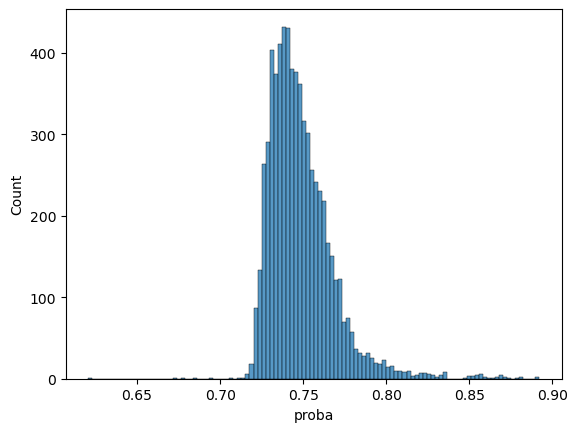

In [208]:
# plot of the latest probabilities
sns.histplot(last_probabilities)
plt.show()

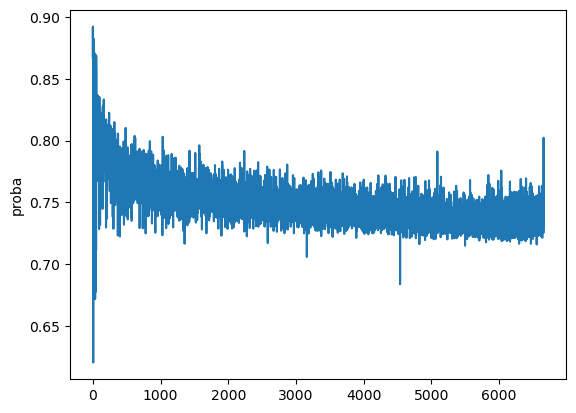

In [209]:
# plot of the the probabilities ranked 
sns.lineplot(last_probabilities)
plt.show()

### Prepare input dataset for round 2 to ASReview

In [196]:
project_path = Path("bib/round2/output/tmp_data")
project_path.mkdir()
project = ASReviewProject.load("bib/round2/output/pubmed-9NOTanimal-set 2-ROUND2.asreview", project_path)

dataset_fp = Path(
    project_path, project.config["id"], "data", project.config["dataset_path"]
)
dataset = ASReviewData.from_file(dataset_fp)
print(f"The dataset contains {len(dataset)} records.")
records = dataset.to_dataframe().reset_index()

The dataset contains 6659 records.


/Users/evaviviani/opt/anaconda3/envs/asreview/lib/python3.12/site-packages/asreview/io/utils.py:142: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(LABEL_NA, inplace=True)


In [197]:
records.head()

,record_id,Unnamed: 0,title,authors,type_of_reference,abstract,language,keywords,doi,ranking,Included
0,0,5540,Temperature-dependent transmission of rotaviru...,"[""{'author': 'Atchison, C J', 'author_abbrevia...",JOUR,"In Europe, rotavirus gastroenteritis peaks in ...","In Europe, rotavirus gastroenteritis peaks in ...",,10.1098/rspb.2009.1755,0,1.0
1,1,993,Climate variability and campylobacter infectio...,"[""{'author': 'Kovats, R Sari', 'author_abbrevi...",JOUR,Campylobacter is among the most important agen...,eng,,10.1007/s00484-004-0241-3,1,1.0
2,2,5186,Seasonality and the effects of weather on Camp...,"[""{'author': 'Djennad, Abdelmajid', 'author_ab...",JOUR,BACKGROUND: Campylobacteriosis is a major publ...,eng,"['Campylobacter', 'Climate change', 'Environme...",10.1186/s12879-019-3840-7,2,1.0
3,3,1566,Determinants of Rotavirus Transmission: A Lag ...,"[""{'author': 'van Gaalen, Rolina D', 'author_a...",JOUR,Rotavirus is a common viral infection among yo...,eng,,10.1097/EDE.0000000000000654,3,1.0
4,4,3179,Influence of weather and climate on cryptospor...,"[""{'author': 'Ikiroma, Isotein Adalia', 'autho...",JOUR,Studies have shown that climatic factors can s...,eng,"['climate', 'cryptosporidiosis', 'public healt...",10.1111/zph.12785,4,1.0


In [198]:
# remove old record_id -- this is the one reflecting the input file
records = records.drop(columns=['Unnamed: 0'])

In [199]:
records.head()

,record_id,title,authors,type_of_reference,abstract,language,keywords,doi,ranking,Included
0,0,Temperature-dependent transmission of rotaviru...,"[""{'author': 'Atchison, C J', 'author_abbrevia...",JOUR,"In Europe, rotavirus gastroenteritis peaks in ...","In Europe, rotavirus gastroenteritis peaks in ...",,10.1098/rspb.2009.1755,0,1.0
1,1,Climate variability and campylobacter infectio...,"[""{'author': 'Kovats, R Sari', 'author_abbrevi...",JOUR,Campylobacter is among the most important agen...,eng,,10.1007/s00484-004-0241-3,1,1.0
2,2,Seasonality and the effects of weather on Camp...,"[""{'author': 'Djennad, Abdelmajid', 'author_ab...",JOUR,BACKGROUND: Campylobacteriosis is a major publ...,eng,"['Campylobacter', 'Climate change', 'Environme...",10.1186/s12879-019-3840-7,2,1.0
3,3,Determinants of Rotavirus Transmission: A Lag ...,"[""{'author': 'van Gaalen, Rolina D', 'author_a...",JOUR,Rotavirus is a common viral infection among yo...,eng,,10.1097/EDE.0000000000000654,3,1.0
4,4,Influence of weather and climate on cryptospor...,"[""{'author': 'Ikiroma, Isotein Adalia', 'autho...",JOUR,Studies have shown that climatic factors can s...,eng,"['climate', 'cryptosporidiosis', 'public healt...",10.1111/zph.12785,4,1.0


In [200]:
records['already_seen'] = [1 if included in [1,0] else 0 for included in records['Included']]

In [201]:
# rename ranking to reflect that this is the old ranking (i.e., round1)
records = records.rename(columns = {'ranking': 'ranking_round1'})

In [202]:
records.head(2)

,record_id,title,authors,type_of_reference,abstract,language,keywords,doi,ranking_round1,Included,already_seen
0,0,Temperature-dependent transmission of rotaviru...,"[""{'author': 'Atchison, C J', 'author_abbrevia...",JOUR,"In Europe, rotavirus gastroenteritis peaks in ...","In Europe, rotavirus gastroenteritis peaks in ...",,10.1098/rspb.2009.1755,0,1.0,1
1,1,Climate variability and campylobacter infectio...,"[""{'author': 'Kovats, R Sari', 'author_abbrevi...",JOUR,Campylobacter is among the most important agen...,eng,,10.1007/s00484-004-0241-3,1,1.0,1


In [ ]:
# this is the NEW ranking, i.e., round2
last_ranking[["record_id", "ranking"]].head()

,record_id,ranking
0,2,0
1,0,1
2,14,2
3,9,3
4,17,4


In [ ]:
last_ranking_min = last_ranking[["record_id", "ranking"]]

In [220]:
# relabel ranking to
last_ranking_minimal = last_ranking_min.rename(columns={"ranking": "ranking_round2", "record_id":"record_id_round2"})

In [225]:
last_ranking_minimal[last_ranking_minimal['record_id_round2'] == 100]

,record_id_round2,ranking_round2
79,100,79


In [226]:
len(last_ranking_minimal[["record_id_round2", "ranking_round2"]])

6659

In [227]:
last_ranking_minimal.head(2)

,record_id_round2,ranking_round2
0,2,0
1,0,1


In [228]:
records.head(2)

,record_id,title,authors,type_of_reference,abstract,language,keywords,doi,ranking_round1,Included,already_seen
0,0,Temperature-dependent transmission of rotaviru...,"[""{'author': 'Atchison, C J', 'author_abbrevia...",JOUR,"In Europe, rotavirus gastroenteritis peaks in ...","In Europe, rotavirus gastroenteritis peaks in ...",,10.1098/rspb.2009.1755,0,1.0,1
1,1,Climate variability and campylobacter infectio...,"[""{'author': 'Kovats, R Sari', 'author_abbrevi...",JOUR,Campylobacter is among the most important agen...,eng,,10.1007/s00484-004-0241-3,1,1.0,1


In [229]:
temp = last_ranking_minimal.merge(records, 
                left_on="record_id_round2",
                right_on="record_id")

In [231]:
temp.head(2)

,record_id_round2,ranking_round2,record_id,title,authors,type_of_reference,abstract,language,keywords,doi,ranking_round1,Included,already_seen
0,2,0,2,Seasonality and the effects of weather on Camp...,"[""{'author': 'Djennad, Abdelmajid', 'author_ab...",JOUR,BACKGROUND: Campylobacteriosis is a major publ...,eng,"['Campylobacter', 'Climate change', 'Environme...",10.1186/s12879-019-3840-7,2,1.0,1
1,0,1,0,Temperature-dependent transmission of rotaviru...,"[""{'author': 'Atchison, C J', 'author_abbrevia...",JOUR,"In Europe, rotavirus gastroenteritis peaks in ...","In Europe, rotavirus gastroenteritis peaks in ...",,10.1098/rspb.2009.1755,0,1.0,1


In [232]:
len(temp[temp['already_seen'] == 1])

53

In [234]:
temp[temp['already_seen'] == 1].sort_values(by='ranking_round1', ascending=True).head(2)

,record_id_round2,ranking_round2,record_id,title,authors,type_of_reference,abstract,language,keywords,doi,ranking_round1,Included,already_seen
1,0,1,0,Temperature-dependent transmission of rotaviru...,"[""{'author': 'Atchison, C J', 'author_abbrevia...",JOUR,"In Europe, rotavirus gastroenteritis peaks in ...","In Europe, rotavirus gastroenteritis peaks in ...",,10.1098/rspb.2009.1755,0,1.0,1
13,1,13,1,Climate variability and campylobacter infectio...,"[""{'author': 'Kovats, R Sari', 'author_abbrevi...",JOUR,Campylobacter is among the most important agen...,eng,,10.1007/s00484-004-0241-3,1,1.0,1


In [235]:
temp.head(2)

,record_id_round2,ranking_round2,record_id,title,authors,type_of_reference,abstract,language,keywords,doi,ranking_round1,Included,already_seen
0,2,0,2,Seasonality and the effects of weather on Camp...,"[""{'author': 'Djennad, Abdelmajid', 'author_ab...",JOUR,BACKGROUND: Campylobacteriosis is a major publ...,eng,"['Campylobacter', 'Climate change', 'Environme...",10.1186/s12879-019-3840-7,2,1.0,1
1,0,1,0,Temperature-dependent transmission of rotaviru...,"[""{'author': 'Atchison, C J', 'author_abbrevia...",JOUR,"In Europe, rotavirus gastroenteritis peaks in ...","In Europe, rotavirus gastroenteritis peaks in ...",,10.1098/rspb.2009.1755,0,1.0,1


In [236]:
ranking_sorted = temp.sort_values(by='ranking_round2', ascending=True)

In [237]:
ranking_sorted

,record_id_round2,ranking_round2,record_id,title,authors,type_of_reference,abstract,language,keywords,doi,ranking_round1,Included,already_seen
0,2,0,2,Seasonality and the effects of weather on Camp...,"[""{'author': 'Djennad, Abdelmajid', 'author_ab...",JOUR,BACKGROUND: Campylobacteriosis is a major publ...,eng,"['Campylobacter', 'Climate change', 'Environme...",10.1186/s12879-019-3840-7,2,1.0,1
1,0,1,0,Temperature-dependent transmission of rotaviru...,"[""{'author': 'Atchison, C J', 'author_abbrevia...",JOUR,"In Europe, rotavirus gastroenteritis peaks in ...","In Europe, rotavirus gastroenteritis peaks in ...",,10.1098/rspb.2009.1755,0,1.0,1
2,14,2,14,Temperature dependence of reported Campylobact...,"[""{'author': 'Tam, C C', 'author_abbreviated':...",JOUR,Campylobacter is the most common bacterial cau...,eng,,10.1017/S0950268805004899,14,1.0,1
3,9,3,9,Weather and notified Campylobacter infections ...,"[""{'author': 'Bi, Peng', 'author_abbreviated':...",JOUR,BACKGROUND: The relationship between weather a...,eng,,10.1016/j.jinf.2008.08.004,9,1.0,1
4,17,4,17,Rotavirus infections and climate variability i...,"[""{'author': 'Hashizume, M', 'author_abbreviat...",JOUR,Attempts to explain the clear seasonality of r...,eng,,10.1017/S0950268807009776,17,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6654,6376,6654,6376,[Prevalence of intestinal parasites in the Max...,"[""{'author': 'Assis, Eliseu Miranda de', 'auth...",JOUR,A prevalence survey using the TF-Test techniqu...,por,,10.1590/s0102-311x2013000800006,6376,-1.0,0
6655,4152,6655,4152,Longitudinal Changes in Skin Microbiome Associ...,"[""{'author': 'Wang, Hailun', 'author_abbreviat...",JOUR,The aim of this study was to identify key micr...,eng,"['microbial diversity', 'psoriasis', 'skin sta...",10.2340/00015555-3638,4152,-1.0,0
6656,5239,6656,5239,The microbiome of pediatric patients with chro...,"['{\'author\': \'Stapleton, Amanda L\', \'auth...",JOUR,BACKGROUND: This study aimed to compare the mi...,eng,"['adenoidectomy', 'adenoids', 'child', 'microb...",10.1002/alr.22597,5239,-1.0,0
6657,6186,6657,6186,Maternal sucralose exposure induces Paneth cel...,"[""{'author': 'Dai, Xin', 'author_abbreviated':...",JOUR,Research has shown that maternal sucralose (MS...,eng,,10.1039/d1fo02921e,6186,-1.0,0


In [238]:
np.sum(ranking_sorted['already_seen'])

53

In [240]:
ranking_sorted[ranking_sorted['already_seen'] == 1].head(2)

,record_id_round2,ranking_round2,record_id,title,authors,type_of_reference,abstract,language,keywords,doi,ranking_round1,Included,already_seen
0,2,0,2,Seasonality and the effects of weather on Camp...,"[""{'author': 'Djennad, Abdelmajid', 'author_ab...",JOUR,BACKGROUND: Campylobacteriosis is a major publ...,eng,"['Campylobacter', 'Climate change', 'Environme...",10.1186/s12879-019-3840-7,2,1.0,1
1,0,1,0,Temperature-dependent transmission of rotaviru...,"[""{'author': 'Atchison, C J', 'author_abbrevia...",JOUR,"In Europe, rotavirus gastroenteritis peaks in ...","In Europe, rotavirus gastroenteritis peaks in ...",,10.1098/rspb.2009.1755,0,1.0,1


In [241]:
# export predictions to give to ASReview for round2
ranking_sorted.to_excel('bib/round2/predictions-round2.xlsx', index=False)

## look at the results of round2

#### load the feedback given by vaness from the ranking that ASReview did in round 2

In [205]:
round2 = pd.read_excel('bib/round2/feedback/predictions-round2_vch-feedback.xlsx', header=0)

In [206]:
round2 = round2.rename(columns = {'Unnamed: 13': 'relevant'})

In [207]:
round2.head()

,record_id_round2,ranking_round2,record_id,title,authors,type_of_reference,abstract,language,keywords,doi,ranking_round1,Included,already_seen,relevant,Unnamed: 14
0,77,35,77,Seasonality of cryptosporidiosis: A meta-analy...,"[""{'author': 'Jagai, Jyotsna S', 'author_abbre...",JOUR,OBJECTIVES: We developed methodology for and c...,eng,NaN,10.1016/j.envres.2009.02.008,77,-1,0,1.0,NaN
1,59,36,59,The temporal pattern and relationship of Campy...,"[""{'author': 'Lindqvist, Roland', 'author_abbr...",JOUR,Thermophilic Campylobacter species are the mos...,eng,"['Data resolution', 'Fresh broiler meat', 'Sea...",10.1016/j.ijfoodmicro.2022.109823,59,-1,0,1.0,NaN
2,87,37,87,Seasonality of rotavirus in South Asia: a meta...,"[""{'author': 'Jagai, Jyotsna S', 'author_abbre...",JOUR,BACKGROUND: Rotavirus infection causes a signi...,eng,NaN,10.1371/journal.pone.0038168,87,-1,0,1.0,NaN
3,97,38,97,Assessing the impact of environmental exposure...,"[""{'author': 'Brankston, Gabrielle', 'author_a...",JOUR,Cryptosporidium is a waterborne parasite that ...,eng,NaN,10.1371/journal.pone.0196573,97,-1,0,1.0,NaN
4,74,42,74,Effects of climatic factors and particulate ma...,"[""{'author': 'Oh, Eun Ju', 'author_abbreviated...",JOUR,Rotavirus A is the most common cause of infect...,eng,"['Climate', 'Diarrhea-causing virus', 'Infecti...",10.1007/s11356-021-13852-3,74,-1,0,1.0,NaN


In [208]:
# adjust the columns in a way that what's in relevant, is encoded in Included

# Update the 'Included' column where 'relevant' is not NaN
round2.loc[:, 'Included'] = round2.loc[:, 'relevant'].combine_first(round2.loc[:, 'Included'])

In [209]:
# update already_seen to be 1 where 'relevant' is not NaN
round2.loc[:, 'already_seen'] = np.where(round2.loc[:, 'relevant'].notna(), 1, round2.loc[:, 'already_seen'])

In [210]:
# remove 'relevant' as this is not useful anymore and the empty column 'Unnamed: 14'
round2 = round2.drop(columns=['relevant', 'Unnamed: 14'])

In [211]:
round2.head()

,record_id_round2,ranking_round2,record_id,title,authors,type_of_reference,abstract,language,keywords,doi,ranking_round1,Included,already_seen
0,77,35,77,Seasonality of cryptosporidiosis: A meta-analy...,"[""{'author': 'Jagai, Jyotsna S', 'author_abbre...",JOUR,OBJECTIVES: We developed methodology for and c...,eng,NaN,10.1016/j.envres.2009.02.008,77,1,1
1,59,36,59,The temporal pattern and relationship of Campy...,"[""{'author': 'Lindqvist, Roland', 'author_abbr...",JOUR,Thermophilic Campylobacter species are the mos...,eng,"['Data resolution', 'Fresh broiler meat', 'Sea...",10.1016/j.ijfoodmicro.2022.109823,59,1,1
2,87,37,87,Seasonality of rotavirus in South Asia: a meta...,"[""{'author': 'Jagai, Jyotsna S', 'author_abbre...",JOUR,BACKGROUND: Rotavirus infection causes a signi...,eng,NaN,10.1371/journal.pone.0038168,87,1,1
3,97,38,97,Assessing the impact of environmental exposure...,"[""{'author': 'Brankston, Gabrielle', 'author_a...",JOUR,Cryptosporidium is a waterborne parasite that ...,eng,NaN,10.1371/journal.pone.0196573,97,1,1
4,74,42,74,Effects of climatic factors and particulate ma...,"[""{'author': 'Oh, Eun Ju', 'author_abbreviated...",JOUR,Rotavirus A is the most common cause of infect...,eng,"['Climate', 'Diarrhea-causing virus', 'Infecti...",10.1007/s11356-021-13852-3,74,1,1


In [140]:
print(f'We found {np.sum(round2['Included'] == 1)} relevant papers so far')

We found 92 relevant papers so far


In [141]:
print(f'Over {np.sum(round2['already_seen'] == 1)} papers reviewed')

Over 102 papers reviewed


In [142]:
print(f'This is about {round((np.sum(round2['Included'] == 1) / np.sum(round2['already_seen'] == 1)) * 100)}% recall')

This is about 90% recall


In [143]:
seen_r2 = round2[round2['already_seen'] == 1]

In [144]:
seen_r2 = seen_r2.sort_values(by=['ranking_round2'], ascending=True)

In [145]:
seen_r2.head()

,record_id_round2,ranking_round2,record_id,title,authors,type_of_reference,abstract,language,keywords,doi,ranking_round1,Included,already_seen
6606,2,0,2,Seasonality and the effects of weather on Camp...,"[""{'author': 'Djennad, Abdelmajid', 'author_ab...",JOUR,BACKGROUND: Campylobacteriosis is a major publ...,eng,"['Campylobacter', 'Climate change', 'Environme...",10.1186/s12879-019-3840-7,2,1,1
6607,0,1,0,Temperature-dependent transmission of rotaviru...,"[""{'author': 'Atchison, C J', 'author_abbrevia...",JOUR,"In Europe, rotavirus gastroenteritis peaks in ...","In Europe, rotavirus gastroenteritis peaks in ...",NaN,10.1098/rspb.2009.1755,0,1,1
6608,14,2,14,Temperature dependence of reported Campylobact...,"[""{'author': 'Tam, C C', 'author_abbreviated':...",JOUR,Campylobacter is the most common bacterial cau...,eng,NaN,10.1017/S0950268805004899,14,1,1
6609,9,3,9,Weather and notified Campylobacter infections ...,"[""{'author': 'Bi, Peng', 'author_abbreviated':...",JOUR,BACKGROUND: The relationship between weather a...,eng,NaN,10.1016/j.jinf.2008.08.004,9,1,1
6610,17,4,17,Rotavirus infections and climate variability i...,"[""{'author': 'Hashizume, M', 'author_abbreviat...",JOUR,Attempts to explain the clear seasonality of r...,eng,NaN,10.1017/S0950268807009776,17,1,1


In [146]:
# how many relevant papers we got? 
seen_r2['n_relevant'] = seen_r2['Included'].cumsum()

In [148]:
# order ranking
seen_r2['n_paper'] = np.arange(len(seen_r2))+1

In [151]:
seen_r2.head()

,record_id_round2,ranking_round2,record_id,title,authors,type_of_reference,abstract,language,keywords,doi,ranking_round1,Included,already_seen,n_relevant,n_paper
6606,2,0,2,Seasonality and the effects of weather on Camp...,"[""{'author': 'Djennad, Abdelmajid', 'author_ab...",JOUR,BACKGROUND: Campylobacteriosis is a major publ...,eng,"['Campylobacter', 'Climate change', 'Environme...",10.1186/s12879-019-3840-7,2,1,1,1,1
6607,0,1,0,Temperature-dependent transmission of rotaviru...,"[""{'author': 'Atchison, C J', 'author_abbrevia...",JOUR,"In Europe, rotavirus gastroenteritis peaks in ...","In Europe, rotavirus gastroenteritis peaks in ...",NaN,10.1098/rspb.2009.1755,0,1,1,2,2
6608,14,2,14,Temperature dependence of reported Campylobact...,"[""{'author': 'Tam, C C', 'author_abbreviated':...",JOUR,Campylobacter is the most common bacterial cau...,eng,NaN,10.1017/S0950268805004899,14,1,1,3,3
6609,9,3,9,Weather and notified Campylobacter infections ...,"[""{'author': 'Bi, Peng', 'author_abbreviated':...",JOUR,BACKGROUND: The relationship between weather a...,eng,NaN,10.1016/j.jinf.2008.08.004,9,1,1,4,4
6610,17,4,17,Rotavirus infections and climate variability i...,"[""{'author': 'Hashizume, M', 'author_abbreviat...",JOUR,Attempts to explain the clear seasonality of r...,eng,NaN,10.1017/S0950268807009776,17,1,1,5,5


In [111]:
seen_r2.shape

(102, 14)

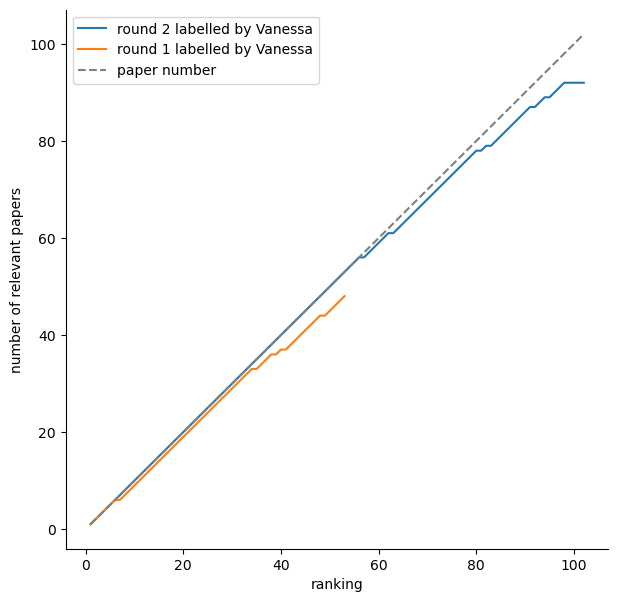

In [169]:
plt.figure(figsize=(7,7))
plt.plot(seen_r2['n_paper'], seen_r2['n_relevant'], label='round 2 labelled by Vanessa')
plt.plot(round1_sub['ranking'], round1_sub['n_relevant'], label='round 1 labelled by Vanessa')
plt.plot(seen_r2['n_paper'], seen_r2['n_paper'], label='paper number', c='gray', linestyle='--')
plt.ylabel('number of relevant papers')
plt.xlabel('ranking')
plt.legend()
sns.despine()
plt.show()

In [175]:
seen_r2_minimal = seen_r2[['n_paper', 'n_relevant']].astype('int')

In [176]:
seen_r2_minimal = seen_r2_minimal.rename(columns={"n_paper": "category", "n_relevant": "Relevant by ASReview LAB"})

In [177]:
seen_r2_minimal.head()

,category,Relevant by ASReview LAB
6606,1,1
6607,2,2
6608,3,3
6609,4,4
6610,5,5


#### knee method, round2

10 10
stopping criterion found


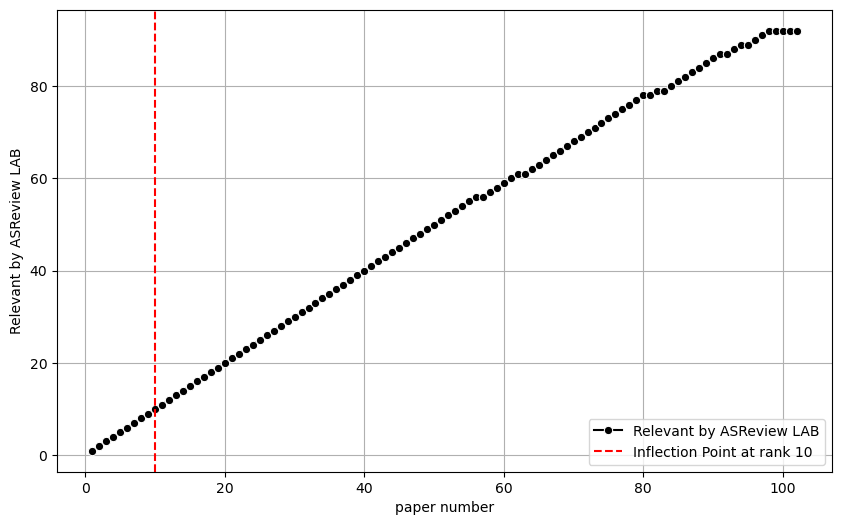

In [191]:
# can we stop already reviewing?
k = 10
rho = 6

# 70% 
i, s, num_relevant, slope_ratio = calculate_knee_values(k, rho, seen_r2_minimal)

In [192]:
# to-do: need to see the function what is actually doing

In [193]:
print('We stop at s=' + str(s) + ' since the slope from 0 to i='
      + str(i) + ' is ' + str(round(slope_ratio, 2)) + ' times higher '
     + 'than the intermediate slope between i and s.')

We stop at s=10 since the slope from 0 to i=1 is 19.06 times higher than the intermediate slope between i and s.


### Prepare dataset for input to ASReview in round3

In [213]:
round2_sorted = round2.sort_values(by=['ranking_round2'], ascending=True)

In [214]:
round2_sorted.head()

,record_id_round2,ranking_round2,record_id,title,authors,type_of_reference,abstract,language,keywords,doi,ranking_round1,Included,already_seen
6606,2,0,2,Seasonality and the effects of weather on Camp...,"[""{'author': 'Djennad, Abdelmajid', 'author_ab...",JOUR,BACKGROUND: Campylobacteriosis is a major publ...,eng,"['Campylobacter', 'Climate change', 'Environme...",10.1186/s12879-019-3840-7,2,1,1
6607,0,1,0,Temperature-dependent transmission of rotaviru...,"[""{'author': 'Atchison, C J', 'author_abbrevia...",JOUR,"In Europe, rotavirus gastroenteritis peaks in ...","In Europe, rotavirus gastroenteritis peaks in ...",NaN,10.1098/rspb.2009.1755,0,1,1
6608,14,2,14,Temperature dependence of reported Campylobact...,"[""{'author': 'Tam, C C', 'author_abbreviated':...",JOUR,Campylobacter is the most common bacterial cau...,eng,NaN,10.1017/S0950268805004899,14,1,1
6609,9,3,9,Weather and notified Campylobacter infections ...,"[""{'author': 'Bi, Peng', 'author_abbreviated':...",JOUR,BACKGROUND: The relationship between weather a...,eng,NaN,10.1016/j.jinf.2008.08.004,9,1,1
6610,17,4,17,Rotavirus infections and climate variability i...,"[""{'author': 'Hashizume, M', 'author_abbreviat...",JOUR,Attempts to explain the clear seasonality of r...,eng,NaN,10.1017/S0950268807009776,17,1,1


In [298]:
round2_sorted_training = round2_sorted.drop(columns=['record_id', 'ranking_round1'])

In [299]:
round2_sorted_training.to_excel('bib/round3/input/training-round3.xlsx', index=False)

`round2_sorted_training` is given to ASReview as input for a new round of training

#### Prepare excel file for 3 round of feedback from Vanessa. This is based on the training output of ASReview of round2 feedback

Extract the last ranking, that is, ranking at the last iteration of round3

In [317]:
with open_state("bib/round3/output/pubmed-9NOTanimal-set 2-ROUND3.asreview") as state:
    last_ranking = state.get_last_ranking()
    last_probabilities = state.get_last_probabilities()
print("RANKING:")
print(last_ranking[["record_id", "ranking"]])
print("RELEVANCE SCORES:")
print(last_probabilities)

RANKING:
      record_id  ranking
0             0        0
1             2        1
2             3        2
3            28        3
4             9        4
...         ...      ...
6654       4600     6654
6655        274     6655
6656       4653     6656
6657        181     6657
6658         56     6658

[6659 rows x 2 columns]
RELEVANCE SCORES:
0       0.914124
1       0.908617
2       0.912845
3       0.911471
4       0.883079
          ...   
6654    0.738755
6655    0.735638
6656    0.726259
6657    0.728886
6658    0.731541
Name: proba, Length: 6659, dtype: float64


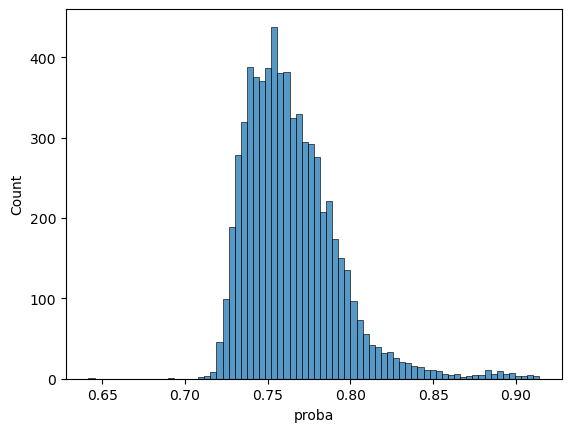

In [318]:
# plot of the latest probabilities
sns.histplot(last_probabilities)
plt.show()

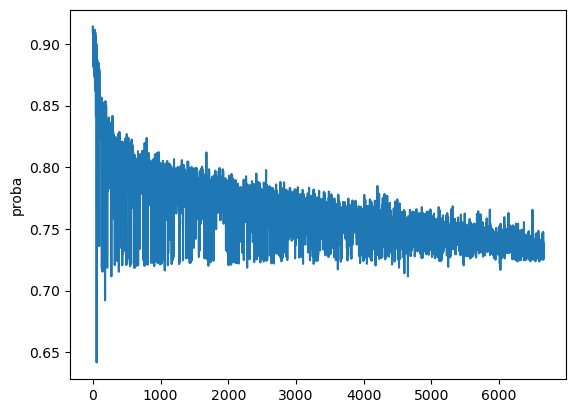

In [319]:
# plot of the the probabilities ranked 
sns.lineplot(last_probabilities)
plt.show()

In [320]:
project_path = Path("bib/round3/output/tmp_data")
project_path.mkdir()
project = ASReviewProject.load("bib/round3/output/pubmed-9NOTanimal-set 2-ROUND3.asreview", project_path)

dataset_fp = Path(
    project_path, project.config["id"], "data", project.config["dataset_path"]
)

dataset = ASReviewData.from_file(dataset_fp)
print(f"The dataset contains {len(dataset)} records.")
records_r3 = dataset.to_dataframe().reset_index()

The dataset contains 6659 records.


/Users/evaviviani/opt/anaconda3/envs/asreview/lib/python3.12/site-packages/asreview/io/utils.py:142: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(LABEL_NA, inplace=True)


In [324]:
records_r3.head(2)

,record_id,record_id_round2,ranking_round2,title,authors,type_of_reference,abstract,language,keywords,doi,Included,already_seen
0,0,2,0,Seasonality and the effects of weather on Camp...,"[""{'author': 'Djennad, Abdelmajid', 'author_ab...",JOUR,BACKGROUND: Campylobacteriosis is a major publ...,eng,"['Campylobacter', 'Climate change', 'Environme...",10.1186/s12879-019-3840-7,1,1
1,1,0,1,Temperature-dependent transmission of rotaviru...,"[""{'author': 'Atchison, C J', 'author_abbrevia...",JOUR,"In Europe, rotavirus gastroenteritis peaks in ...","In Europe, rotavirus gastroenteritis peaks in ...",,10.1098/rspb.2009.1755,1,1


In [325]:
last_ranking.head()

,record_id,ranking,classifier,query_strategy,balance_strategy,feature_extraction,training_set,time
0,0,0,nb,max,double,tfidf,102,2024-07-31 13:14:18.354899
1,2,1,nb,max,double,tfidf,102,2024-07-31 13:14:18.354899
2,3,2,nb,max,double,tfidf,102,2024-07-31 13:14:18.354899
3,28,3,nb,max,double,tfidf,102,2024-07-31 13:14:18.354899
4,9,4,nb,max,double,tfidf,102,2024-07-31 13:14:18.354899


In [326]:
last_ranking_min = last_ranking[["record_id", "ranking"]]

In [327]:
# relabel ranking to
last_ranking_minimal = last_ranking_min.rename(columns={"ranking": "ranking_round3", "record_id":"record_id_round3"})

In [328]:
last_ranking_minimal.head(100)

,record_id_round3,ranking_round3
0,0,0
1,2,1
2,3,2
3,28,3
4,9,4
...,...,...
95,60,95
96,107,96
97,148,97
98,98,98


In [329]:
temp = last_ranking_minimal.merge(records_r3, 
                left_on="record_id_round3",
                right_on="record_id")

In [333]:
temp.head(2)

,record_id_round3,ranking_round3,record_id,record_id_round2,ranking_round2,title,authors,type_of_reference,abstract,language,keywords,doi,Included,already_seen
0,0,0,0,2,0,Seasonality and the effects of weather on Camp...,"[""{'author': 'Djennad, Abdelmajid', 'author_ab...",JOUR,BACKGROUND: Campylobacteriosis is a major publ...,eng,"['Campylobacter', 'Climate change', 'Environme...",10.1186/s12879-019-3840-7,1,1
1,2,1,2,14,2,Temperature dependence of reported Campylobact...,"[""{'author': 'Tam, C C', 'author_abbreviated':...",JOUR,Campylobacter is the most common bacterial cau...,eng,,10.1017/S0950268805004899,1,1


In [334]:
len(temp[temp['already_seen'] == 1])

102

In [335]:
ranking_sorted = temp.sort_values(by='ranking_round3', ascending=True)

In [336]:
ranking_sorted.head(2)

,record_id_round3,ranking_round3,record_id,record_id_round2,ranking_round2,title,authors,type_of_reference,abstract,language,keywords,doi,Included,already_seen
0,0,0,0,2,0,Seasonality and the effects of weather on Camp...,"[""{'author': 'Djennad, Abdelmajid', 'author_ab...",JOUR,BACKGROUND: Campylobacteriosis is a major publ...,eng,"['Campylobacter', 'Climate change', 'Environme...",10.1186/s12879-019-3840-7,1,1
1,2,1,2,14,2,Temperature dependence of reported Campylobact...,"[""{'author': 'Tam, C C', 'author_abbreviated':...",JOUR,Campylobacter is the most common bacterial cau...,eng,,10.1017/S0950268805004899,1,1


In [337]:
# export predictions to give to ASReview for round2
ranking_sorted.to_excel('bib/round3/predictions-round3.xlsx', index=False)